In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import dill
from IPython.core import display as ICD  # to print multiple nice pandas tables
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import tqdm
from tqdm import tqdm_notebook, tnrange
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import datasets
import classify
from simple_model import SimpleModel
from testing import test_simple_model

In [9]:
from collections import defaultdict
results = defaultdict(dict)
dump = defaultdict(dict)

In [10]:
def gradient_w(model, dataset, alpha=0.01, epochs=150):
    train_scores = []
    valid_scores = []
    test_scores = []
    model.fit(dataset.train_samples(), dataset.train_labels())
    if epochs is None:
        t = tnrange(100000)
    else:
        t = tnrange(epochs)
    for e in t:
        w = np.copy(model.w)
        w -= alpha * model.dw(dataset.train_samples(), dataset.train_labels())
        model.w = np.copy(w)
        model.fit(dataset.train_samples(), dataset.train_labels())
        train_score = model.score(dataset.train_samples(), dataset.train_labels())
        valid_score = model.score(dataset.valid_samples(), dataset.valid_labels())
        test_score = model.score(dataset.test_samples(), dataset.test_labels())
        train_scores.append(train_score)
        valid_scores.append(valid_score)
        test_scores.append(test_score)
        t.set_postfix(train_score=train_score, valid_score=valid_score, test_score=test_score)
        if epochs is None and e > 30:
            end_mean = np.mean(valid_scores[-10:])
            previos_mean = np.mean(valid_scores[-20:-10])
            t.set_postfix(train_score=train_score, valid_score=valid_score, test_score=test_score, previos=previos_mean, end=end_mean)
            if end_mean < previos_mean:
                break
    plt.plot(train_scores)
    plt.plot(valid_scores)
    plt.plot(test_scores)
    plt.legend(['train', 'valid', 'test'])
    plt.show()
    return train_scores, valid_scores, test_scores

In [11]:
def test_simple_model_with_gradient(model, dataset, gradient_iters=300, dims=300, alpha=0.01, tag=None, results=None, dump=None, with_models=False):
    train_ps, valid_ps, test_ps = gradient_w(model, dataset, alpha, gradient_iters)
    #train_p = model.score(dataset.train_samples(), dataset.train_labels())
    #test_p = model.score(dataset.test_samples(), dataset.test_labels())
    
    train_p = np.mean(train_ps[-10:])
    valid_p = np.mean(valid_ps[-10:])
    test_p = np.mean(test_ps[-10:])
    if results is not None:
        results[dataset.name()][('batch', tag, alpha, dims, 'train')] = train_p
        results[dataset.name()][('batch', tag, alpha, dims, 'valid')] = valid_p
        results[dataset.name()][('batch', tag, alpha, dims, 'test')] = test_p
        
    if dump is not None:
        dump[dataset.name()][('batch', tag, alpha)] = {
            'train': list(train_ps),
            'valid': list(valid_ps),
            'test': list(test_ps),
            'w': list(model.w),
            'dict': model.dictionary.token2id
        }
        if with_models:
            dump[dataset.name()][('batch', tag, alpha)]['model']= model
            
        
    #raw_results[dataset.name()][('gradientw', tag, alpha)] = (train_ps, test_ps)
    print(dataset.name())
    print("Train precision", train_p)
    print("Valid precision", valid_p)
    print("Test precision", test_p)

CRDataset None 0.1 200 CRDataset_None_0.1_200


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

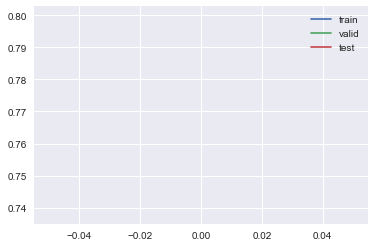

CRDataset
Train precision 0.7996688741721855
Valid precision 0.7453580901856764
Test precision 0.7380952380952381
[0.99807178 1.03034053 1.0110947  ... 1.00023201 1.00023201 0.99995258]


TypeError: key ('batch', 'None', 0.1, 200, 'test') is not a string

In [16]:
start = True
start_on = ''

for dataset in datasets.ALL_DATASETS:
    for scheme in SimpleModel.SCHEMES:
        for alpha in [0.1, 0.01, 0.001]:
            for dims in [200, 300, 400]:
                tag = '{}_{}_{}_{}'.format(dataset.name(), scheme, alpha, dims)
                if not start:
                    start = (tag == start_on)
                    continue
                print(dataset.name(), scheme, alpha, dims, tag)
                model = SimpleModel(classify.SkClassifier(), use_svd=True, weights=scheme)
                test_simple_model_with_gradient(
                    model, dataset, alpha=alpha, dims=dims, tag=scheme, gradient_iters=None, results=results, dump=dump, with_models=False)
                print(model.w)
                results_file = 'dumps/batch_results_{}.json'.format(tag)
                dumps_file = 'dumps/batch_dump_{}.json'.format(tag)
                if True:
                    json.dump(results, open(results_file, 'w'))
                    json.dump(dump, open(dumps_file, 'w'))

                

In [81]:
loaded = pickle.load(open(dumps_file,'rb'))

In [82]:
loaded

defaultdict(dict,
            {'CRDataset': {('batch',
               'None',
               0.1): {'test': [0.7407407407407407], 'train': [0.8009933774834437], 'valid': [0.7427055702917772], 'w': array([0.99809537, 1.02989234, 1.01274645, ..., 1.00023726, 1.00023726,
                      0.99996376])}}})

In [ ]:
pd.DataFrame(results)